In [1]:
import tensorflow as tf 
print(tf.__version__)

2023-11-09 23:36:34.911226: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 23:36:35.475222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 23:36:35.475268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 23:36:35.477156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 23:36:36.637426: I tensorflow/core/platform/cpu_feature_g

2.14.0


In [3]:
!git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset


Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035
Receiving objects: 100% (3039/3039), 79.25 MiB | 1.25 MiB/s, done.
Updating files: 100% (3264/3264), done.


In [4]:
!ls

brain-tumor-classification-dataset  main.ipynb


In [5]:
!mv brain-tumor-classification-dataset dataset

In [2]:
import os 

for dirpath, dirnames, filenames in os.walk("dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'dataset'.
There are 4 directories and 0 images in 'dataset/Testing'.
There are 0 directories and 74 images in 'dataset/Testing/pituitary_tumor'.
There are 0 directories and 115 images in 'dataset/Testing/meningioma_tumor'.
There are 0 directories and 105 images in 'dataset/Testing/no_tumor'.
There are 0 directories and 100 images in 'dataset/Testing/glioma_tumor'.
There are 4 directories and 0 images in 'dataset/Training'.
There are 0 directories and 827 images in 'dataset/Training/pituitary_tumor'.
There are 0 directories and 822 images in 'dataset/Training/meningioma_tumor'.
There are 0 directories and 395 images in 'dataset/Training/no_tumor'.
There are 0 directories and 826 images in 'dataset/Training/glioma_tumor'.


In [3]:
#getting the classnames 
import pathlib
import numpy as np
data_dir = pathlib.Path("dataset/Training//")
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
print(class_names)

['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [4]:
train_dir = "dataset/Training/"
test_dir = "dataset/Testing/"

In [5]:
# visualing an random image from any class

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import random 

def view_random_image(target_dir, target_class):

    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder+"/"+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape : {img.shape}")
    return img 


Image shape : (260, 236, 3)


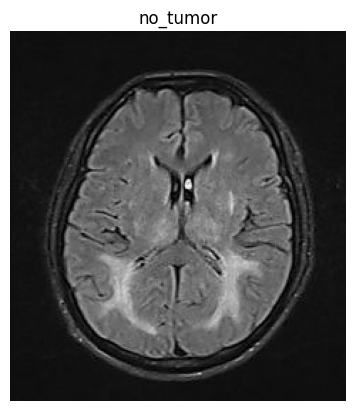

In [6]:
img = view_random_image(test_dir, random.choice(class_names))

## Preprocessing the images

In [7]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [8]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


## Creating a EfficientNetB0 model

In [9]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [10]:
import tensorflow_hub as hub

In [11]:
def create_model(model_url,num_classes):

    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             input_shape=(224,224,3))

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes,activation="softmax",name="output_layer")
    ])
    return model 

In [12]:
efficientnet_model = create_model(efficientnet_url,4)

2023-11-09 23:36:52.817713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 23:36:52.870094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 23:36:52.870136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 23:36:52.873901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-09 23:36:52.873947: I tensorflow/compile

In [13]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [14]:
efficientnet_history = efficientnet_model.fit(train_data,epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5


2023-11-09 23:37:13.781150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-09 23:37:15.167541: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-09 23:37:16.728574: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-09 23:37:22.812154: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe150121850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-09 23:37:22.812213: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2023-11-09 23:37:22.852624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/90 [..............................] - ETA: 28:59 - loss: 1.4635 - accuracy: 0.1875

2023-11-09 23:37:23.052964: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 [==============================] - 64s 498ms/step - loss: 0.8358 - accuracy: 0.6787 - val_loss: 1.0791 - val_accuracy: 0.5431
Epoch 2/5
90/90 [==============================] - 35s 380ms/step - loss: 0.5075 - accuracy: 0.8254 - val_loss: 1.1228 - val_accuracy: 0.5584
Epoch 3/5
90/90 [==============================] - 35s 382ms/step - loss: 0.4220 - accuracy: 0.8554 - val_loss: 1.0575 - val_accuracy: 0.6066
Epoch 4/5
90/90 [==============================] - 35s 382ms/step - loss: 0.3764 - accuracy: 0.8718 - val_loss: 1.0786 - val_accuracy: 0.6218
Epoch 5/5
90/90 [==============================] - 35s 385ms/step - loss: 0.3421 - accuracy: 0.8840 - val_loss: 1.0536 - val_accuracy: 0.6574


In [15]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4054688 (15.47 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [16]:
#function to display loss curve 
import matplotlib.pyplot as plt 
import numpy as np

def plot_loss_curve(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs,accuracy,label="training accuracy")
    plt.plot(epochs,val_accuracy,label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,loss,label="training loss")
    plt.plot(epochs,val_loss,label="validation loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()


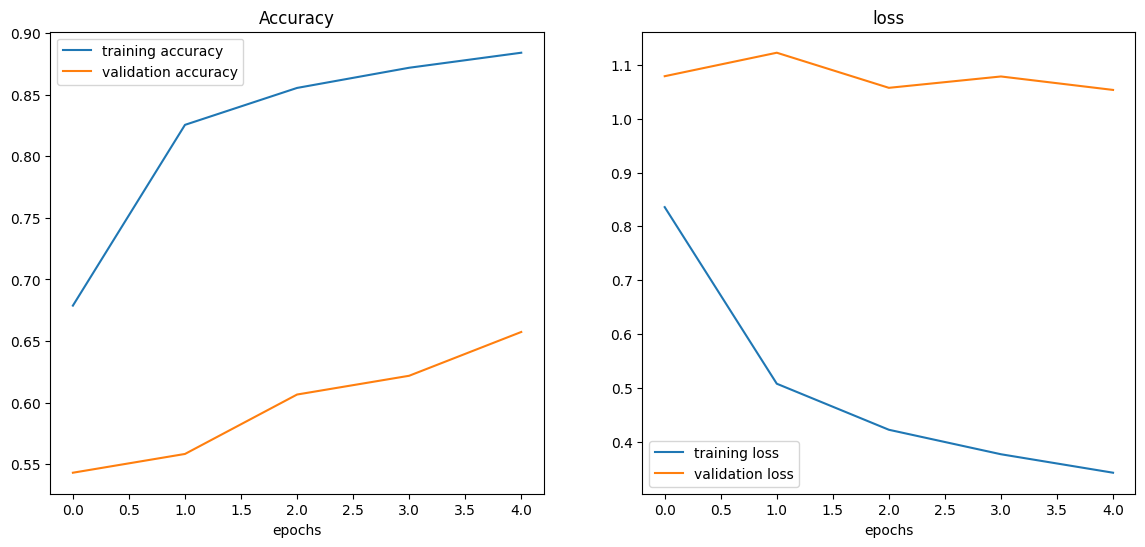

In [17]:
plot_loss_curve(efficientnet_history)

## Trying data augmentation 

In [18]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                batch_size=32,
                                                                target_size=(224,224),
                                                                class_mode="categorical",
                                                                shuffle=True)

Found 2870 images belonging to 4 classes.


In [19]:
efficientnet_model_2 = create_model(efficientnet_url,4)

efficientnet_model_2.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

efficientnet_history_2 = efficientnet_model_2.fit(train_data_augmented,epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))


Epoch 1/5
90/90 [==============================] - 55s 447ms/step - loss: 0.8744 - accuracy: 0.6467 - val_loss: 1.2153 - val_accuracy: 0.4924
Epoch 2/5
90/90 [==============================] - 47s 515ms/step - loss: 0.5816 - accuracy: 0.7889 - val_loss: 1.1651 - val_accuracy: 0.5812
Epoch 3/5
90/90 [==============================] - 47s 520ms/step - loss: 0.4987 - accuracy: 0.8178 - val_loss: 1.1856 - val_accuracy: 0.5939
Epoch 4/5
90/90 [==============================] - ETA: 0s - loss: 0.4552 - accuracy: 0.8317

In [ ]:
plot_loss_curve(efficientnet_history_2)